---
title: "Asset Allocation & Investment Strategies - 2nd Assignment"
author:
  - Group 1
  - Azim Balci, Mayeul Perret, Rodolphe Lajugie, Theodosis Kaplanidis, Zihua Du
date: "2026-02-02"
format: pdf
---
\newpage
\tableofcontents
\listoffigures
\listoftables
\newpage

## Importing Python Libraries and Statistical Packages

In [1]:
import pandas as pd
import numpy as np
import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
import re

## Data Description and Loading


In this section, we load the two datasets used throughout the analysis.

The first dataset contains the monthly Fama–French risk factors and the risk-free rate.  It provides the market excess return (Mkt_RF), the size factor (SMB), the value factor (HML), and the one-month risk-free rate (RF). These variables are used as explanatory factors in the asset pricing regressions.

The second dataset contains the monthly excess returns of the 25 Fama–French portfolios formed on size and book-to-market equity. We focus on value-weighted portfolio returns, which serve as the dependent variables in the time-series regressions.

In [2]:
# Load value-weighted monthly portfolio returns
portfolios_vw = pd.read_excel(
    "25_Portfolios_5x5_clean.xlsx",
    sheet_name="VW Returns Monthly")

# Clean header structure
portfolios_vw = portfolios_vw.iloc[1:].reset_index(drop=True)
portfolios_vw.columns = portfolios_vw.iloc[0]
portfolios_vw = portfolios_vw.iloc[1:].reset_index(drop=True)
portfolios_vw["Date"] = pd.to_datetime(portfolios_vw["Date"])

# Convert portfolio returns from percent to decimal
portfolio_cols = [col for col in portfolios_vw.columns if col != "Date"]
for col in portfolio_cols:
    portfolios_vw[col] = pd.to_numeric(portfolios_vw[col]) / 100

# Load Fama-French factors data
ff_factors = pd.read_excel(
    "F-F_Research_Data_Factors_clean.xlsx",
    sheet_name="Monthly Excess Returns")

# Merge portfolios with risk-free rate
data = portfolios_vw.merge(
    ff_factors[["Date", "RF"]],
    on="Date",
    how="inner")

# Compute excess returns for each portfolio
for col in portfolio_cols:
    data[col] = data[col] - data["RF"]

# Keep excess portfolio returns only
excess_portfolios = data.drop(columns=["RF"])

## Sample Period and Data Preparation for the CAPM

We begin by evaluating the performance of the single-factor CAPM over the sample period studied by Fama and French (1993). Following the original analysis, we restrict the data to the period from January 1964 to January 1993.

The excess returns of the 25 Fama–French portfolios and the market excess return are used as inputs in the subsequent time-series regressions.

In [3]:
# Define sample period
start_date = "1964-01-01"
end_date = "1993-01-01"

# Restrict portfolio excess returns to the sample period
excess_portfolios_sample = excess_portfolios[
    (excess_portfolios["Date"] >= start_date) &
    (excess_portfolios["Date"] <= end_date)
].reset_index(drop=True)

# Restrict factor data to the same sample period
ff_factors_sample = ff_factors[
    (ff_factors["Date"] >= start_date) &
    (ff_factors["Date"] <= end_date)
].reset_index(drop=True)

# Keep market excess return only for CAPM
mkt_excess = ff_factors_sample[["Date", "Mkt_RF"]]

## Question i

We evaluate the performance of the single-factor CAPM by estimating, for each of the 25 Fama–French portfolios, the following time-series regression over the period January 1964 to January 1993:

$$
r_{i,t} = \alpha_i + \beta_i \, Mkt\_RF_t + \varepsilon_{i,t},
$$

where $r_{i,t}$ denotes the excess return on portfolio $i$ and $Mkt\_RF_t$ is the market excess return. For each portfolio, we report the mean excess return, the estimated CAPM beta and its t-statistic, the estimated alpha and its t-statistic, and the adjusted $R^2$.

In [4]:
#| tbl-cap: "CAPM Results for the 25 Fama–French Portfolios (1964–1993)"
# Run CAPM time-series regressions for the 25 portfolios

# Merge portfolio excess returns with market excess return
reg_data = excess_portfolios_sample.merge(
    ff_factors_sample[["Date", "Mkt_RF"]],
    on="Date",
    how="inner")

# Identify portfolio columns
portfolio_cols = [col for col in reg_data.columns
                  if col not in ["Date", "Mkt_RF"]]


# Container for regression results
results = []

# Loop over portfolios and estimate CAPM regressions
for col in portfolio_cols:
    y = reg_data[col]
    X = sm.add_constant(reg_data["Mkt_RF"])
    model = sm.OLS(y, X).fit()
    
    results.append({
        "Portfolio": col,
        "Mean Excess Return": y.mean(),
        "Beta": model.params["Mkt_RF"],
        "Beta t-stat": model.tvalues["Mkt_RF"],
        "Alpha": model.params["const"],
        "Alpha t-stat": model.tvalues["const"],
        "Adj. R2": model.rsquared_adj
    })

# Collect results in a DataFrame
capm_results = pd.DataFrame(results)
capm_results.round(4)

,Portfolio,Mean Excess Return,Beta,Beta t-stat,Alpha,Alpha t-stat,Adj. R2
0,SMALL LoBM,0.0031,1.4259,27.7989,-0.0026,-1.1263,0.6892
1,ME1 BM2,0.0074,1.2505,28.1828,0.0024,1.1866,0.6951
2,ME1 BM3,0.0078,1.1589,28.6577,0.0032,1.7260,0.7021
3,ME1 BM4,0.0094,1.0770,26.8673,0.0051,2.7940,0.6744
4,SMALL HiBM,0.0108,1.1030,24.1851,0.0064,3.0815,0.6266
5,ME2 BM1,0.0040,1.4284,37.1472,-0.0017,-0.9625,0.7985
6,ME2 BM2,0.0066,1.2345,37.4424,0.0016,1.0795,0.8010
7,ME2 BM3,0.0088,1.1160,35.5970,0.0043,3.0376,0.7844
8,ME2 BM4,0.0096,1.0331,34.7449,0.0054,3.9913,0.7761
9,ME2 BM5,0.0108,1.1233,30.0869,0.0062,3.6639,0.7221


In [5]:
# Create robust 5x5 tables (no NaN) using strict portfolio name mapping

size_map = {"1": "Small", "2": "2", "3": "3", "4": "4", "5": "Big"}
bm_map = {"1": "Low", "2": "2", "3": "3", "4": "4", "5": "High"}

def parse_portfolio_strict(name):
    if name.startswith("SMALL"):
        return "Small", ("Low" if "LoBM" in name else "High")
    if name.startswith("BIG"):
        return "Big", ("Low" if "LoBM" in name else "High")
    m = re.match(r"ME(\d)\s+BM(\d)", name)
    if m:
        return size_map[m.group(1)], bm_map[m.group(2)]
    return pd.NA, pd.NA

capm_results[["Size", "BM"]] = capm_results["Portfolio"].apply(
    lambda x: pd.Series(parse_portfolio_strict(x))
)

size_order = ["Small", "2", "3", "4", "Big"]
bm_order = ["Low", "2", "3", "4", "High"]

def make_5x5(var):
    out = capm_results.pivot(index="Size", columns="BM", values=var)
    return out.loc[size_order, bm_order]

mean_5x5   = make_5x5("Mean Excess Return")
beta_5x5   = make_5x5("Beta")
beta_t_5x5 = make_5x5("Beta t-stat")
alpha_5x5  = make_5x5("Alpha")
alpha_t_5x5= make_5x5("Alpha t-stat")
r2_5x5     = make_5x5("Adj. R2")

In [6]:
#| tbl-cap: "Mean Excess Returns of the 25 Fama–French Portfolios (1964–1993)"
#| label: tbl-excess-returns
mean_5x5

BM,Low,2,3,4,High
Size,,,,,
Small,0.003090,0.007425,0.007840,0.009437,0.010844
2,0.004047,0.006582,0.008828,0.009565,0.010755
3,0.004491,0.006975,0.007049,0.008792,0.010202
4,0.004657,0.004035,0.006177,0.008066,0.009194
Big,0.003263,0.003467,0.003490,0.005139,0.006125


In [7]:
#| tbl-cap: "CAPM Betas for the 25 Fama–French Portfolios (1964–1993)"
#| label: tbl-betas
beta_5x5

BM,Low,2,3,4,High
Size,,,,,
Small,1.425884,1.250530,1.158853,1.077028,1.103020
2,1.428427,1.234521,1.116015,1.033107,1.123314
3,1.353789,1.162876,1.033577,0.975694,1.069104
4,1.223638,1.128797,1.034855,0.973928,1.081046
Big,1.001999,0.982546,0.866932,0.834828,0.870462


In [8]:
#| tbl-cap: "t-Statistics of CAPM Betas for the 25 Fama–French Portfolios (1964–1993)"
# | label: tbl-betas-t-stats
beta_t_5x5

BM,Low,2,3,4,High
Size,,,,,
Small,27.798851,28.182754,28.657677,26.867342,24.185137
2,37.147215,37.442397,35.597026,34.744860,30.086892
3,45.604053,45.617558,41.500499,39.040635,30.741266
4,55.263285,57.108716,49.793979,39.517688,33.602720
Big,49.686748,58.557294,40.036931,36.661585,26.605966


In [9]:
#| tbl-cap: "CAPM Alphas for the 25 Fama–French Portfolios (1964–1993)"
#| label: tbl-alphas
alpha_5x5

BM,Low,2,3,4,High
Size,,,,,
Small,-0.002637,0.002403,0.003186,0.005112,0.006414
2,-0.001689,0.001625,0.004346,0.005416,0.006243
3,-0.000945,0.002305,0.002898,0.004873,0.005908
4,-0.000257,-0.000498,0.002021,0.004155,0.004853
Big,-0.000761,-0.000479,0.000008,0.001786,0.002629


In [10]:
#| tbl-cap: "t-Statistics of CAPM Alphas for the 25 Fama–French Portfolios (1964–1993)"
#| label: tbl-alphas-t-stats
alpha_t_5x5

BM,Low,2,3,4,High
Size,,,,,
Small,-1.126317,1.186556,1.726040,2.793956,3.081514
2,-0.962518,1.079549,3.037569,3.991288,3.663913
3,-0.697838,1.981224,2.549935,4.272519,3.722447
4,-0.254490,-0.552534,2.130326,3.693725,3.305077
Big,-0.826358,-0.625438,0.008073,1.718931,1.760606


In [11]:
#| tbl-cap: "CAPM R-squared for the 25 Fama–French Portfolios (1964–1993)"
#| label: tbl-r2
r2_5x5

BM,Low,2,3,4,High
Size,,,,,
Small,0.689224,0.695076,0.702122,0.674418,0.626578
2,0.798485,0.801022,0.784406,0.776091,0.722094
3,0.856597,0.856670,0.831826,0.814020,0.730655
4,0.897678,0.903559,0.876877,0.817672,0.764250
Big,0.876410,0.907838,0.821534,0.794213,0.670104


## Question ii

@tbl-excess-returns reveals two distinct patterns in portfolio excess returns. Moving east (from low to high B/M, i.e. from growth to value stocks), we observe a consistent and pronounced increase in average returns across virtually all size categories. For small-cap stocks, returns rise from 0.31% for growth stocks to 1.08% for value stocks, representing more than a threefold increase. For large-cap stocks, the increase is more modest (from 0.33% to 0.61%), but remains monotonic. Overall, the value premium appears highly persistent across the size dimension.

By contrast, moving south (from small to large firms), the size effect is far less systematic. While small-cap value stocks earn substantially higher returns than their large-cap counterparts (1.08% versus 0.61%), returns within the growth category are of comparable magnitude across firm sizes. Moreover, for intermediate B/M portfolios, average returns do not vary monotonically with size and often peak in the middle size categories.

Taken together, the evidence suggests that the value premium plays a more prominent role in shaping the cross-section of average returns than the size effect. The highest returns are concentrated in the north-east quadrant (small value stocks), whereas the lowest returns are observed in the south-west quadrant (large growth stocks).

## Question iii

To address this question, we examine the estimated CAPM betas reported in @tbl-betas. The results reveal a clear asymmetry across portfolios. Value stocks consistently exhibit lower market betas than growth stocks, yet earn higher average excess returns. This pattern directly contradicts the CAPM prediction that expected returns should increase monotonically with exposure to systematic market risk.

By contrast, the size effect appears broadly consistent with CAPM. Small-cap portfolios tend to have higher market betas and, on average, earn higher returns than large-cap portfolios, which is in line with compensation for greater exposure to market risk.

The value premium, however, constitutes a genuine asset pricing puzzle. High B/M portfolios display lower exposure to market risk than low B/M portfolios within each size category, yet consistently achieve higher average returns. According to the CAPM and mean–variance theory, assets with lower systematic risk should command lower expected returns. The empirical evidence therefore suggests that market beta alone is insufficient to explain the observed cross-section of returns.

This finding points to the presence of additional priced risk factors beyond the market factor and directly motivates the development of multifactor asset pricing models, such as the Fama–French model, which we explore in subsequent analysis.

## Question iv

Examining the t-statistics reported in @tbl-alphas-t-stats, we find that a substantial fraction of the estimated alphas are statistically significant at conventional confidence levels, particularly among portfolios with medium and high book-to-market ratios. Within the CAPM framework, the intercept term represents the component of average returns that cannot be explained by exposure to the market factor. The presence of statistically significant alphas therefore indicates that the CAPM fails to fully account for the cross-section of expected returns.

Turning to the adjusted $R^2$, values in @tbl-r2, we observe that they are generally high, ranging from approximately 0.63 to 0.91. This implies that the market factor explains a large share of the time-series variation in portfolio returns. However, the explanatory power of the CAPM tends to decline as the book-to-market ratio increases, consistent with the weaker fit of the model for value portfolios.

Taken together, these results suggest that while the CAPM performs reasonably well in explaining fluctuations in returns over time, it performs poorly in explaining differences in average returns across portfolios. The existence of significant alphas highlights the inability of the single-factor CAPM to price the cross-section of returns.

## Question v

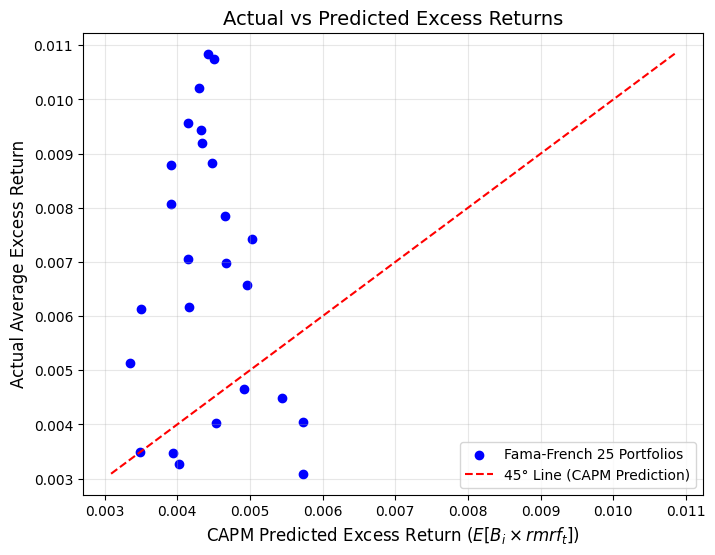

In [12]:
#| fig-cap: "Actual vs Predicted Excess Returns"

# Predicted Returns
mkt_mean_excess = reg_data["Mkt_RF"].mean()
capm_results["Predicted Return"] = capm_results["Beta"] * mkt_mean_excess

plt.figure(figsize=(8, 6))

plt.scatter(capm_results["Predicted Return"],
            capm_results["Mean Excess Return"],
            color='blue', label='Fama-French 25 Portfolios')

min_val = min(capm_results["Predicted Return"].min(),
              capm_results["Mean Excess Return"].min()) # for 45° line

max_val = max(capm_results["Predicted Return"].max(),
              capm_results["Mean Excess Return"].max()) # for 45° line

line_coords = np.linspace(min_val, max_val, 100)

plt.plot(line_coords, line_coords, color='red',
         linestyle='--', label='45° Line (CAPM Prediction)')

plt.xlabel(
    'CAPM Predicted Excess Return ($E[B_i \\times rmrf_t]$)', fontsize=12)

plt.ylabel('Actual Average Excess Return', fontsize=12)

plt.title('Actual vs Predicted Excess Returns', fontsize=14)

plt.legend()

plt.grid(True, alpha=0.3)

The figure plots average realized excess returns against the excess returns predicted by the CAPM, $E[\beta_i r_{m,t}^{e}] = \beta_i \, E[r_{m,t}^{e}]$, along with the 45-degree line. If the CAPM were able to explain the cross-section of returns, all portfolios would lie close to this line. Instead, the scatter plot reveals substantial deviations from the CAPM prediction.
Predicted excess returns are tightly clustered, ranging approximately between 0.35% and 0.55% per month, reflecting the relatively small dispersion in estimated betas across portfolios. In contrast, actual average excess returns are much more dispersed, ranging from about 0.3% to over 1.1% per month. As a result, value portfolios tend to lie well above the 45-degree line, while growth portfolios lie below it.
This pattern provides clear visual evidence that the CAPM fails to account for the observed cross-sectional variation in average returns, despite its ability to explain a large fraction of time-series return variation.

## Question vi

Our findings indicate that while the CAPM retains some practical value, its explanatory power is fundamentally incomplete.

In the time series dimension, the model performs relatively well. The market factor alone accounts for a large share of month-to-month variation in returns, with adjusted $R^2$ values ranging from approximately 0.67 to 0.91 across the 25 portfolios. This suggests that market risk remains an important driver of short-run return dynamics. However, when shifting to the cross-section, where the core prediction of the CAPM is that differences in average returns should be explained by differences in beta, the empirical evidence clearly contradicts the model.

Market betas vary only modestly across portfolios, generating a narrow range of predicted excess returns, while realized average excess returns are far more dispersed. As a result, many portfolios exhibit statistically significant pricing errors. The most severe failure arises for value portfolios: high book-to-market portfolios earn consistently higher average returns despite having lower exposure to market risk than growth portfolios, directly violating the CAPM’s risk-return trade-off.

That said, the CAPM is not entirely without merit. For a subset of portfolios, estimated alphas are not statistically different from zero, indicating that market beta alone can sometimes provide a reasonable approximation of expected returns. Moreover, the model remains useful for understanding comovements in returns over time.

Overall, the CAPM has limited “hope”: it serves as a useful benchmark and explains time-series variation reasonably well, but it fails to explain the cross-sectional structure of expected returns in the Fama–French 25 portfolios. Capturing these patterns requires additional priced risk factors, such as size and value.

## Question vii

In [13]:
def capm_results_for_sample(start_date, end_date):
    # filter returns data based on the date chosen
    excess_portfolios_q9 = excess_portfolios[
        (excess_portfolios["Date"] >= start_date) &
        (excess_portfolios["Date"] <= end_date)
    ].copy()

    # filter factor data based on the date chosen (need Mkt_RF)
    factors_q9 = ff_factors[
        (ff_factors["Date"] >= start_date) &
        (ff_factors["Date"] <= end_date)
    ][["Date", "Mkt_RF"]].copy()

    # merge to one data frame and align dates
    reg_s = excess_portfolios_q9.merge(factors_q9, on="Date", how="inner")

    # run CAPM regressions portfolio-by-portfolio
    results = []
    for col in portfolio_cols:
        y = reg_s[col]
        X = sm.add_constant(reg_s["Mkt_RF"])
        model = sm.OLS(y, X).fit()

        results.append({
            "Portfolio": col,
            "Mean Excess Return": float(y.mean()),
            "Beta": float(model.params["Mkt_RF"]),
            "Beta t-stat": float(model.tvalues["Mkt_RF"]),
            "Alpha": float(model.params["const"]),
            "Alpha t-stat": float(model.tvalues["const"]),
            "Adj. R2": float(model.rsquared_adj)
        })

    capm_res = pd.DataFrame(results)
    return capm_res, reg_s


def plot_actual_vs_predicted(capm_res, reg_s, title):
    mkt_mean_excess = float(reg_s["Mkt_RF"].mean())
    # predicted = beta * market excess return
    capm_res["Predicted Return"] = capm_res["Beta"] * mkt_mean_excess

    # plot the dots for each portfolio
    plt.figure(figsize=(8, 6))
    plt.scatter(capm_res["Predicted Return"],
            capm_res["Mean Excess Return"], label="Fama-French 25 Portfolios")

    min_val = min(capm_res["Predicted Return"].min(),
              capm_res["Mean Excess Return"].min())
    max_val = max(capm_res["Predicted Return"].max(),
              capm_res["Mean Excess Return"].max())

    line_coords = np.linspace(min_val, max_val, 100)
    plt.plot(line_coords, line_coords, linestyle="--", label="45° Line (CAPM)")

    plt.xlabel(r"CAPM Predicted Excess Return ($E[\beta_i \times mktrf_t]$)")
    plt.ylabel("Actual Average Excess Return")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

In [14]:
size_order = ["Small", "2", "3", "4", "Big"]
bm_order   = ["Low", "2", "3", "4", "High"]

bm_label = {"Low": "BM1", "2": "BM2", "3": "BM3", "4": "BM4", "High": "BM5"}
size_label = {"Small": "ME1", "2": "ME2", "3": "ME3", "4": "ME4", "Big": "ME5"}

In [15]:
capm_results_64to93, reg_data_64to93 = capm_results_for_sample(
    "1964-01-01", "1993-01-01")

In [16]:
def prepare_pred_vs_actual(capm_res, reg_s):
    capm_res = capm_res.copy()

    # add predicted return (same as your code)
    mkt_mean_excess = float(reg_s["Mkt_RF"].mean())
    capm_res["Predicted Return"] = capm_res["Beta"] * mkt_mean_excess

    # add size and bm labels
    capm_res[["Size", "BM"]] = capm_res["Portfolio"].apply(
        lambda x: pd.Series(parse_portfolio_strict(x))
    )

    return capm_res

In [17]:
# this function helps label portfolios on plots
def label_point(x, y, text, dx=6, dy=6, fontsize=9):
    plt.annotate(
        text,
        xy=(x, y),
        textcoords="offset points",
        xytext=(dx, dy),
        ha="left",
        fontsize=fontsize
    )

In [18]:
def plot_pred_vs_actual_connect_bm(capm_res, reg_s, title):
    df = prepare_pred_vs_actual(capm_res, reg_s)

    plt.figure(figsize=(8, 6))

    # scatter all points first
    plt.scatter(df["Predicted Return"], df["Mean Excess Return"])

    # connect within each BM (5 lines)
    for bm in bm_order:
        sub = df[df["BM"] == bm].copy()
        sub["Size"] = pd.Categorical(sub["Size"], categories=size_order, 
                                    ordered=True)
        sub = sub.sort_values("Size")

        plt.plot(sub["Predicted Return"], sub["Mean Excess Return"], 
                 marker="o", linewidth=1, label=bm_label[bm])
        
        # we plot only the endpoints in each group
        first = sub.iloc[0]   # Small end
        last  = sub.iloc[-1]  # Big end

        label_point(first["Predicted Return"], first["Mean Excess Return"],
            first["Portfolio"], dx=6, dy=6)
        label_point(last["Predicted Return"], last["Mean Excess Return"],
            last["Portfolio"], dx=6, dy=6)

    # 45-degree line y=x
    min_val = min(df["Predicted Return"].min(), df["Mean Excess Return"].min())
    max_val = max(df["Predicted Return"].max(), df["Mean Excess Return"].max())
    line_coords = np.linspace(min_val, max_val, 100)
    plt.plot(line_coords, line_coords, linestyle="--", label="45° Line (CAPM)")


    plt.xlabel(r"CAPM Predicted Excess Return ($E[\beta_i \times mktrf_t]$)")
    plt.ylabel("Actual Average Excess Return")
    plt.title(title + " — connect within B/M")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

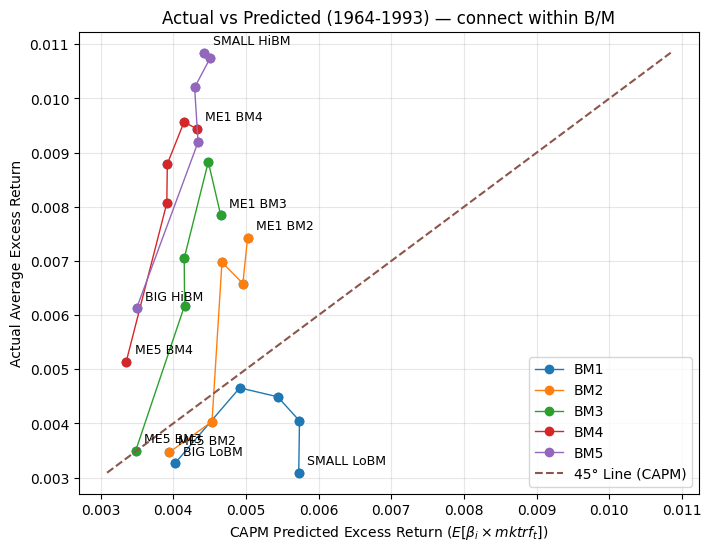

In [19]:
#| fig-cap: "Actual vs Predicted Excess Returns — connect within B/M (1964-1993)"
plot_pred_vs_actual_connect_bm(
    capm_results_64to93,
    reg_data_64to93,
    "Actual vs Predicted (1964-1993)"
)

Connecting portfolios within each book-to-market (B/M) category highlights how the CAPM performs *conditional on B/M*. Within a given B/M group, there is at best a weak-to-moderate positive association between CAPM-predicted excess returns, $E[r_i^{CAPM}] = \beta_i E[r_m^{e}]$, and realized average excess returns: portfolios with slightly higher predicted returns often exhibit somewhat higher realized means. However, the relationship is clearly not tight, especially for low B/M (growth) portfolios, indicating substantial dispersion around the CAPM benchmark even within groups.

More importantly, the lines for different B/M categories are systematically shifted relative to one another. High B/M (value) groups (e.g., BM5) lie well above low B/M (growth) groups (e.g., BM1) for comparable levels of CAPM-predicted returns. This implies that, holding market beta (and thus the CAPM prediction) roughly fixed, value portfolios earn higher average excess returns than growth portfolios. In other words, the value premium appears largely orthogonal to market beta, consistent with a systematic CAPM pricing error.

Finally, examining the endpoints within each B/M category suggests an additional size pattern: within the same B/M group, smaller-size portfolios tend to earn higher average excess returns than larger-size portfolios. This within-group size gradient is not fully captured by differences in beta and therefore reinforces the notion that a single market factor is insufficient. Overall, the connected-line plot provides visual evidence that both value and (to a lesser extent) size effects persist even after conditioning on CAPM-predicted returns, motivating the inclusion of additional priced factors such as SMB and HML.

## Question viii

In [20]:
def plot_pred_vs_actual_connect_size(capm_res, reg_s, title):
    df = prepare_pred_vs_actual(capm_res, reg_s)
    plt.figure(figsize=(8, 6))
    # scatter all points first
    plt.scatter(df["Predicted Return"], df["Mean Excess Return"])

    # connect within each Size (5 lines)
    for sz in size_order:
        sub = df[df["Size"] == sz].copy()
        sub["BM"] = pd.Categorical(sub["BM"], categories=bm_order, ordered=True)
        sub = sub.sort_values("BM")

        plt.plot(sub["Predicted Return"], sub["Mean Excess Return"], 
                 marker="o", linewidth=1, label=size_label[sz])

        # we plot only the endpoints in each group
        first = sub.iloc[0]   # low B/M end
        last  = sub.iloc[-1]  # high B/M end
        label_point(first["Predicted Return"], first["Mean Excess Return"],
            first["Portfolio"], dx=6, dy=6)
        label_point(last["Predicted Return"], last["Mean Excess Return"],
            last["Portfolio"], dx=6, dy=6)
    # 45-degree line y=x
    min_val = min(df["Predicted Return"].min(), df["Mean Excess Return"].min())
    max_val = max(df["Predicted Return"].max(), df["Mean Excess Return"].max())
    line_coords = np.linspace(min_val, max_val, 100)
    plt.plot(line_coords, line_coords, linestyle="--", label="45° Line (CAPM)")
    plt.xlabel(r"CAPM Predicted Excess Return ($E[\beta_i \times mktrf_t]$)")
    plt.ylabel("Actual Average Excess Return")
    plt.title(title + " — connect within Size")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

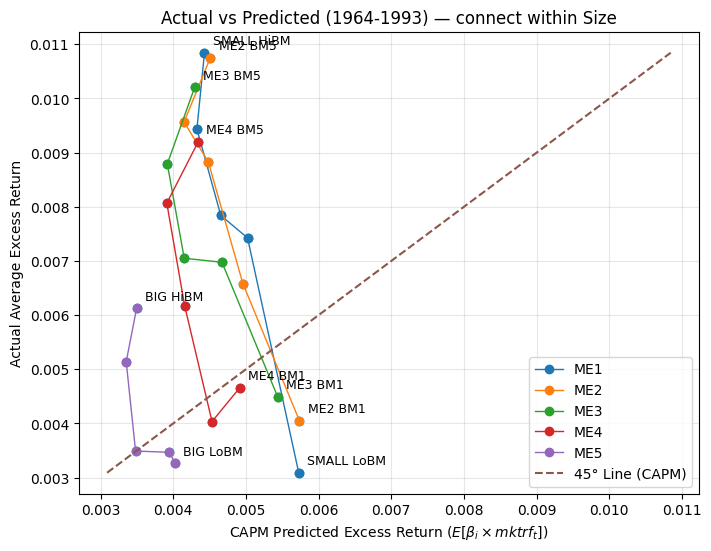

In [21]:
#| fig-cap: "Actual vs Predicted Excess Returns — connect within Size (1964-1993)"
plot_pred_vs_actual_connect_size(
    capm_results_64to93,
    reg_data_64to93,
    "Actual vs Predicted (1964-1993)")

Connecting portfolios within each size category (ME1–ME5) provides a sharp diagnostic of the CAPM’s cross-sectional implications. Within a given size group, there is little evidence of a positive relation between CAPM-predicted excess returns, $E[r_i^{CAPM}] = \beta_i E[r_m^{e}]$, and realized average excess returns. In several size categories the connected lines are flat or even downward-sloping, implying that portfolios with higher CAPM-predicted returns do not systematically earn higher average returns. This pattern directly contradicts the CAPM’s central cross-sectional prediction.

At the same time, a strong value pattern remains visible *within* each size category. The high B/M endpoints (value portfolios) consistently lie above the low B/M endpoints (growth portfolios), indicating that, holding size fixed, value portfolios earn substantially higher average excess returns. Since these differences persist despite only modest variation in market beta, the value premium is largely unexplained by the single-factor CAPM.

Overall, the connected-line plot reinforces the core puzzle: variation in market beta does not account for the large cross-sectional spread in average returns across the 25 portfolios. Instead, return differences appear systematically related to book-to-market (and, in related diagnostics, to size), motivating the need for additional priced factors beyond the market factor, such as HML and SMB.

## Question ix

In [22]:
# for 1/1933–12/1963
capm_results_33to63, reg_data_33to63 = capm_results_for_sample(
    "1933-01-01", "1963-12-31"
)


# for 1/1933–12/2023
capm_results_33to23, reg_data_33to23 = capm_results_for_sample(
    "1933-01-01", "2023-12-31"
)

### Part (a): 1/1933–12/1963

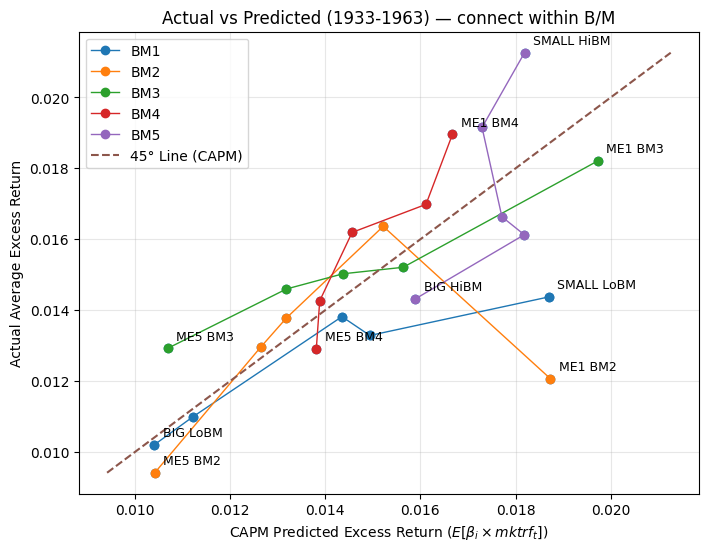

In [23]:
#| fig-cap: "Actual vs Predicted Excess Returns — connect within B/M (1933-1963)"
# 1933–1963
plot_pred_vs_actual_connect_bm(capm_results_33to63, reg_data_33to63,
                               "Actual vs Predicted (1933-1963)")

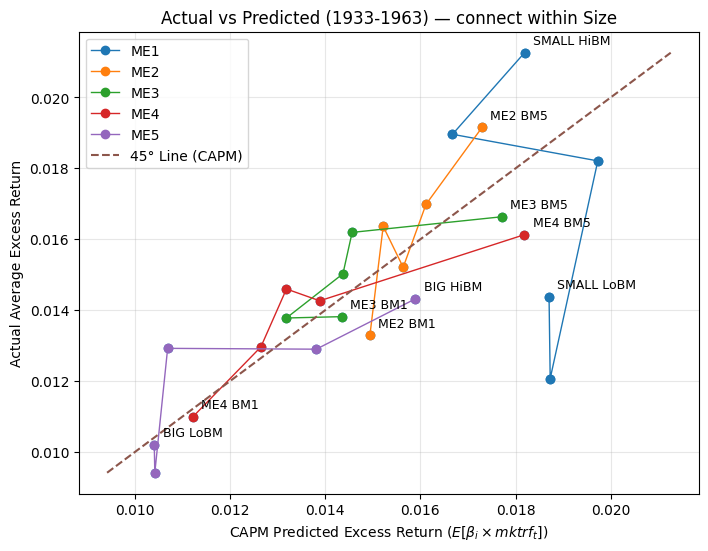

In [24]:
#| fig-cap: "Actual vs Predicted Excess Returns — connect within Size (1933-1963)"
# 1933–1963
plot_pred_vs_actual_connect_size(capm_results_33to63, reg_data_33to63,
                                 "Actual vs Predicted (1933-1963)")

Relative to the 1964–1993 sample, the 1933–1963 plots suggest that the CAPM performs *somewhat better* in the sense that several portfolios lie closer to the 45-degree line, and within-group connected patterns are occasionally more aligned with the CAPM benchmark. Nevertheless, the dispersion around the 45-degree line remains substantial, indicating that the CAPM still fails to fully account for the cross-sectional variation in average returns.

When connecting portfolios within B/M categories, high B/M (value) groups continue to lie above low B/M (growth) groups for comparable CAPM-predicted returns, implying that the value premium is not captured by market beta alone. Similarly, when connecting portfolios within size categories, the relationship between CAPM-predicted and realized average excess returns is weak, and the endpoints again display a pronounced value separation (high B/M portfolios earning higher average returns than low B/M portfolios within the same size group).

Overall, while the CAPM appears to fit the data somewhat more closely in 1933–1963 than in 1964–1993, it still produces systematic pricing errors, consistent with the presence of additional priced sources of risk beyond the market factor.

### Part (b): 1/1933–12/2023

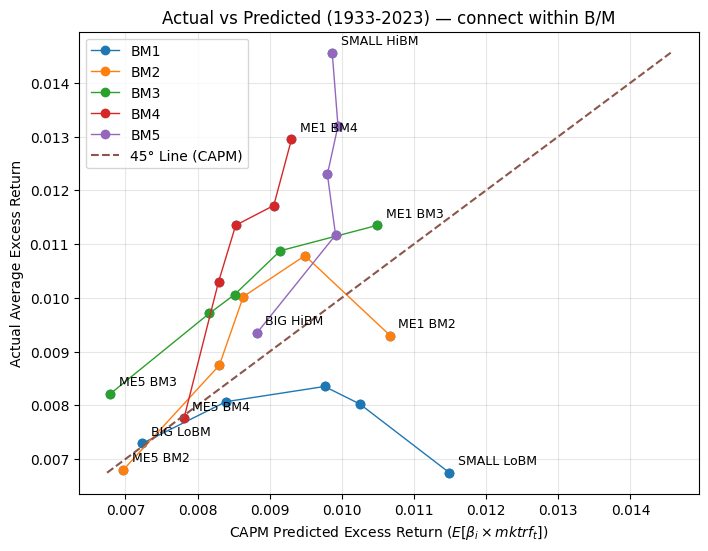

In [25]:
#| fig-cap: "Actual vs Predicted Excess Returns — connect within B/M (1933-2023)"
# 1933–2023
plot_pred_vs_actual_connect_bm(capm_results_33to23, reg_data_33to23,
                               "Actual vs Predicted (1933-2023)")

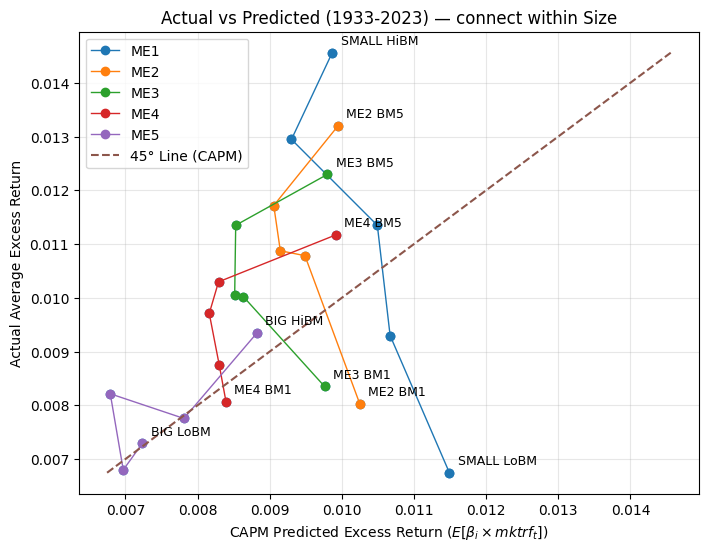

In [26]:
#| fig-cap: "Actual vs Predicted Excess Returns — connect within Size (1933-2023)"
# 1933–2023
plot_pred_vs_actual_connect_size(capm_results_33to23, reg_data_33to23,
                                 "Actual vs Predicted (1933-2023)")

Using the full 1933–2023 sample makes the cross-sectional failure of the CAPM particularly clear. Relative to the shorter subsamples, many portfolios deviate substantially from the 45-degree line, and there is little evidence of groups of portfolios aligning closely with the CAPM prediction. Low B/M (growth) portfolios generally lie at the lower end of the plot, while high B/M (value) portfolios frequently lie well above the CAPM benchmark, earning higher average excess returns than predicted by market beta alone.

When portfolios are connected within B/M categories, the separation across B/M groups remains strong. Likewise, when portfolios are connected within size categories, the connected lines are often flat or downward-sloping, indicating a clear violation of the CAPM’s predicted positive relationship between beta and expected returns. In both representations, the 1933–2023 plots closely resemble those obtained for the 1964–1993 period, suggesting that the value and size effects persist over long horizons.

One possible interpretation is that averaging over a longer sample does not eliminate CAPM pricing errors, but instead reveals their systematic nature. In particular, the assumption of a single, time-invariant market beta may be too restrictive over long horizons, as exposure to risk and economic conditions likely vary over time. Regardless of the interpretation, the empirical evidence indicates that market beta alone is insufficient to explain average returns.

Across all sample periods, a consistent pattern emerges: within each B/M category, smaller portfolios tend to earn higher average excess returns, and within each size category, high B/M portfolios earn higher returns than low B/M portfolios. These regularities cannot be captured by the single-factor CAPM and provide strong motivation for multifactor asset pricing models, such as the Fama–French model, which incorporate additional sources of systematic risk related to size and value.

## Summary

This assignment examined the empirical performance of the single-factor Capital Asset Pricing Model (CAPM) using the 25 Fama–French size and book-to-market sorted portfolios. Focusing initially on the 1964–1993 period and subsequently extending the analysis to earlier and longer samples, we evaluated the model’s ability to explain both time-series variation and cross-sectional differences in average returns.

The time-series evidence indicates that the CAPM performs reasonably well in explaining fluctuations in portfolio returns over time. Estimated market betas are highly statistically significant, and the adjusted $R^2$ values are relatively high, implying that the market factor captures a substantial fraction of return comovements. However, the cross-sectional evidence reveals clear and systematic failures of the model. Average excess returns vary far more across portfolios than can be explained by differences in market beta alone, resulting in economically and statistically significant pricing errors.

In particular, a strong and persistent value effect emerges across all samples: high book-to-market (value) portfolios earn substantially higher average returns than low book-to-market (growth) portfolios, despite having similar or even lower market betas. Size effects are also present, with smaller portfolios generally earning higher returns within book-to-market categories. Scatter plots of actual versus CAPM-predicted excess returns, along with connected-line diagnostics within size and book-to-market groups, provide clear visual evidence that the CAPM fails to account for these patterns.

Extending the analysis to the 1933–1963 and 1933–2023 samples does not restore the cross-sectional validity of the CAPM. While the model appears somewhat closer to the data in the earlier subsample, systematic deviations from the CAPM benchmark persist. Over the full sample, the value and size effects remain pronounced, reinforcing the conclusion that market beta alone is insufficient to explain expected returns.

Overall, the CAPM retains limited usefulness as a benchmark model and as a tool for understanding time-series return dynamics. However, it fails to explain the cross-sectional structure of expected returns in the Fama–French portfolios. These findings provide strong empirical motivation for multifactor asset pricing models, such as the Fama–French framework, which incorporate additional systematic risk factors related to size and value.